In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import shgo
from mpl_toolkits.mplot3d import Axes3D

import topo_generic as topo
import cpp
import importlib
importlib.reload(topo)
importlib.reload(cpp)

#replace with %matplotlib inline if not using jupyter lab / widget
%matplotlib inline

# Energy spectrum (fig2.c)

**Setup computation parameters**

In [2]:
N=11 # number of charge states
nbands=7 # number of excited states to computed
Ej,Ec=1,1 # Josephson and charging energy
asym=[1,1,1] # Asymmetry factor (surface of JJ with fixed plasma frequency)

# compute energy spectrum for different values of $\varphi_X$
phiXList=[0.99*np.pi,np.pi]
dimphiX=len(phiXList)

# compute energy along ng1=ng2
dimng=801
ngList=np.linspace(0,1,dimng)

**Compute energy spectrum of cpp along $n_{g1}=n_{g2}$ for different values of $\varphi_X$**

==> can be skipped to just load data below

In [ ]:
E=np.zeros([nbands,dimphiX,dimng])
for iphiX,phiX in enumerate(phiXList):
    for ing,ng in enumerate(ngList):
        param=[N,Ec,Ej,ng,ng,phiX,asym]
        H=cpp.getH(param)

        E[:,iphiX,ing],temp=topo.compute_ev(H,nbands=nbands)

In [ ]:
# with open('fig2_data/cpp_fig2_spectrum.pkl', 'wb') as outfile:
#     pickle.dump(E,outfile)

**Load data**

In [3]:
with open('fig2_data/cpp_fig2_spectrum.pkl', 'rb') as outfile:
    E=pickle.load(outfile)

**Plot first two excited states for different values of $\varphi_X$**

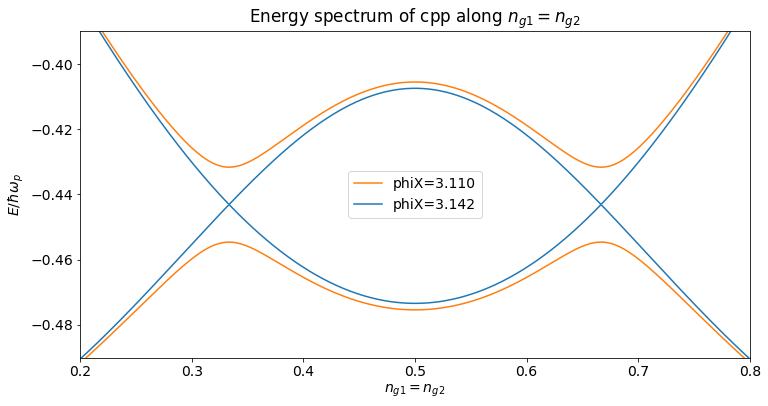

In [10]:
plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 14})

colors=['tab:orange','tab:blue']

for j in range(2):
    #divide by sqrt(2*Ej*Ec) to normalize by plasma frequency
    plt.plot(ngList,E[0,j]/np.sqrt(2*Ej*Ec),color=colors[j],label=f'phiX={phiXList[j]:.3f}')
    plt.plot(ngList,E[1,j]/np.sqrt(2*Ej*Ec),color=colors[j])
    
plt.legend()
plt.title('Energy spectrum of cpp along $n_{g1}=n_{g2}$')
plt.xlabel('$n_{g1}=n_{g2}$')
plt.ylabel('$E/\hbar \omega_p$')
plt.xlim(left=0.2,right=0.8)
plt.ylim(top=-0.39,bottom=-0.49)
plt.show()

# Degeneracy in whole 3D parameter space

**Find degeneracies in the whole cpp parameter space, for a given set of Ej,Ec**

Divide parameter space in few parts, and use SHGO algorithm to look for degeneracies in each subset.

==> can be skipped by just loading datas below

In [ ]:
N=11 # number of charge states
nbands=7 # number of excited states to computed
Ej,Ec=1,1 # Josephson and charging energy
asym=[1,1,1] # Asymmetry factor (surface of JJ with fixed plasma frequency)
tol=1e-8 #tolerance for eigsh eigensolver

#search in subsets of full parameter space
nglist=np.linspace(0,1,5)
dimng=len(nglist)
phiXlist=np.linspace(0,2*np.pi,5)
dimphiX=len(phiXlist)

#store degeneracies gap and position
deg_gap,deg_pos=[],[]

param=[N,Ej,Ec,asym,tol]#initiate parameter for SHGO

for ing1 in range(dimng):
    for ing2 in range(dimng):
        for iphiX in range(dimphiX):
            if ing1==0 or ing2==0 or iphiX==0: continue #skip first element
                
            bnds=( (nglist[ing1-1], nglist[ing1]), (nglist[ing2-1], nglist[ing2]), (phiXlist[iphiX-1],phiXlist[iphiX]) )
            
            temp_deg=shgo(cpp.minimize,bnds,args=param, n=30, iters=4, sampling_method='sobol', \
                          minimizer_kwargs={'method':'SLSQP', 'options':{'options':{'ftol':1e-8, 'eps':1e-10}}}, \
                          options={'ftol':1e-8, 'maxtime':120, 'local_iter':20} )

            for ideg in range(len(temp_deg.funl)):
                if temp_deg.funl[ideg]<1e-5:
                    deg_gap.append(temp_deg.funl[ideg])
                    deg_pos.append(temp_deg.xl[ideg])
                    print(f'gap: {temp_deg.funl[ideg]} \t at (ng1,ng2,phiX)={temp_deg.xl[ideg]}')

In [ ]:
# with open('fig2_data/cpp_fig2_degen.pkl', 'wb') as outfile:
#     pickle.dump([deg_gap,deg_pos],outfile)

**Load degeneracies**

In [6]:
with open('fig2_data/cpp_fig2_degen.pkl', 'rb') as outfile:
    deg_gap,deg_pos=pickle.load(outfile)

**Plot degeneracies in ng1/ng2/phiX parameter space**

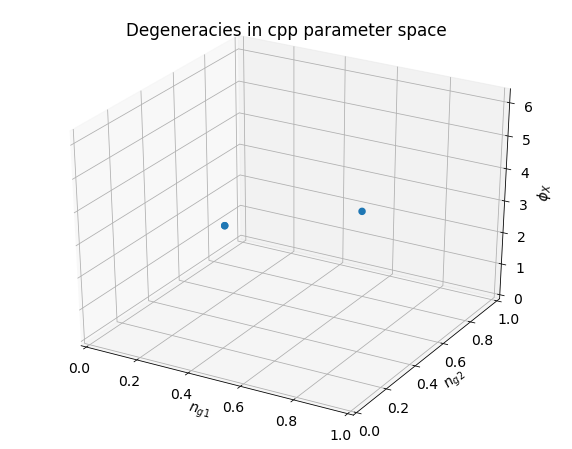

In [9]:
deg_pos=np.array(deg_pos)

fig = plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 14})

ax = fig.add_subplot(111, projection='3d')
plt.title('Degeneracies in cpp parameter space')
ax.scatter(deg_pos[:,0],deg_pos[:,1],deg_pos[:,2],alpha=1,lw=3)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_zlim([0,2*np.pi])
ax.set_xlabel('$n_{g1}$')
ax.set_ylabel('$n_{g2}$')
ax.set_zlabel('$\phi_X$')
plt.show()